Shape: (2, 7555, 6046); 
NoData Value: None; 
Bands: <xarray.DataArray 'band' (band: 2)>
array([1, 2])
Coordinates:
  * band         (band) int64 1 2
    spatial_ref  int64 0; 
Band Names: ('mnf1', 'mnf2'); 
Data Type: float32


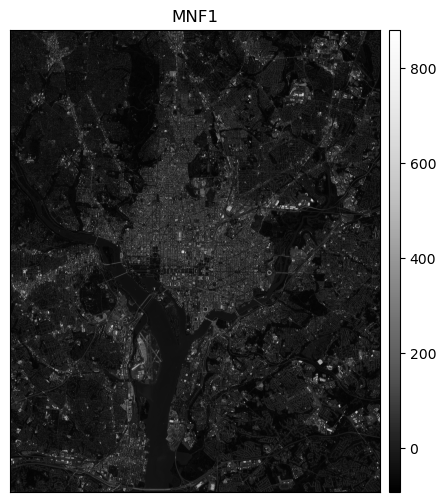

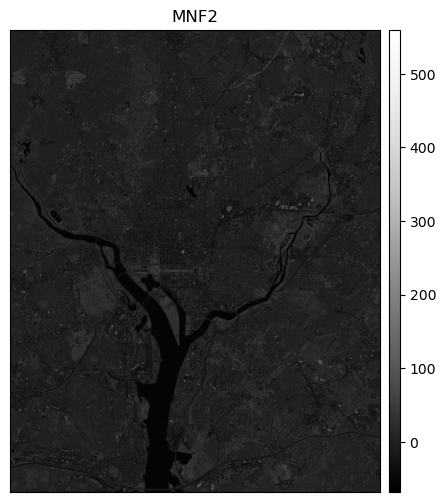

<Axes: title={'center': 'MNF2'}>

In [12]:
############################################################
# Unsupervised classification of the MNF transformed image #
# To create a binary mask of water/veg & built-up          #
############################################################

import os
import time
import numpy as np
import rioxarray as rxr
import xarray as xr
import matplotlib.pyplot as plt
import earthpy.plot as ep
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from skimage import io

projdir = r'/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-urban-fuels/rooftop-materials/'

# Bring in the image file and get the projection information
mnf_path = os.path.join(projdir,'data/spatial/mod/dc_data/planet-data/dc_data_psscene13b_mnf_.tif')
stack_mnf = rxr.open_rasterio(mnf_path)
print(
    f"Shape: {stack_mnf.shape}; \n"
    f"NoData Value: {stack_mnf.rio.nodata}; \n"
    f"Bands: {stack_mnf.band}; \n"
    f"Band Names: {stack_mnf.long_name}; \n"
    f"Data Type: {stack_mnf[0].dtype}")
# Plot one image as an example (green band)
ep.plot_bands(stack_mnf[0], title=["MNF1"], figsize=(6,6))
ep.plot_bands(stack_mnf[1], title=["MNF2"], figsize=(6,6))


In [13]:
def array_to_tif(arr, ref, out_path, dtype, clip=False, shp=None):
    """
    Generate a xarray DataArray with spatial information
    Match dimensions to a reference image
    """
    # Transpose the new array before exporting
    in_arr = arr.transpose(2, 1, 0)
    print(in_arr.shape)
    # Assign the correct coordinates for the transposed 'y' dimension
    band_coords = range(in_arr.shape[0])
    y_coords = ref.y.values
    x_coords = ref.x.values
    # Store the new array and export
    out_arr = xr.DataArray(
        in_arr,
        dims=("band", "y", "x"),
        coords={
            "band": band_coords,
            "y": y_coords,
            "x": x_coords,
        }
    )
    # Export the new DataArray as a new GeoTIFF file
    out_arr.rio.set_crs(ref.rio.crs)  # Set the CRS
    out_arr.rio.write_transform(ref.rio.transform())  # Set the GeoTransform
    if clip is True and shp is not None:
        print("Clipping raster array ...")
        out_arr = out_arr.rio.clip(shp.geometry)
    elif clip is True and shp is None:
        print("Provide a shapefile for clipping geometry ...")
    out_arr.rio.to_raster(out_path, compress='zstd', zstd_level=10,
                          dtype=dtype, driver='GTiff')  # export to GeoTIFF

    print(f"Successfully exported array to '{out_path}'")

    return out_arr

(1, 7555, 6046)
(1, 7555, 6046)
Successfully exported array to '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-urban-fuels/rooftop-materials/data/spatial/mod/dc_data/results/dc_data_mnf_kmeans3.tif'


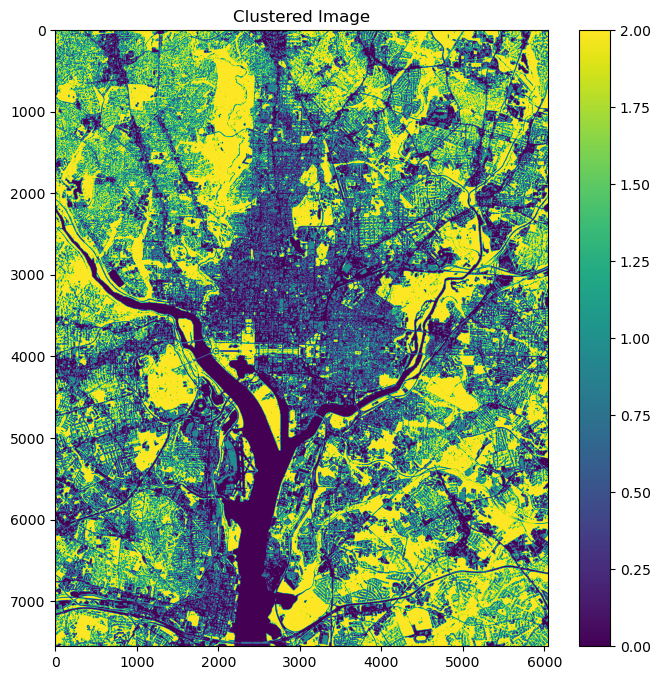

(1, 7555, 6046)
(1, 7555, 6046)
Successfully exported array to '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-urban-fuels/rooftop-materials/data/spatial/mod/dc_data/results/dc_data_mnf_kmeans5.tif'


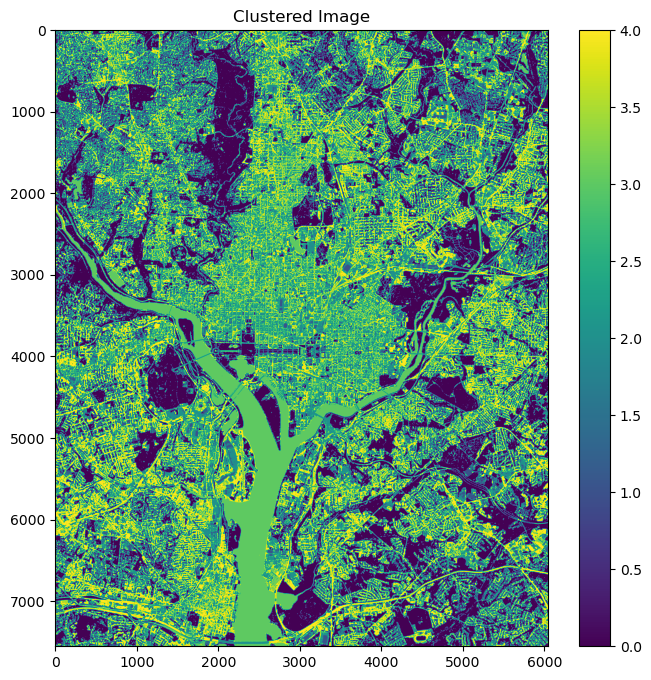

(1, 7555, 6046)
(1, 7555, 6046)
Successfully exported array to '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-urban-fuels/rooftop-materials/data/spatial/mod/dc_data/results/dc_data_mnf_kmeans7.tif'


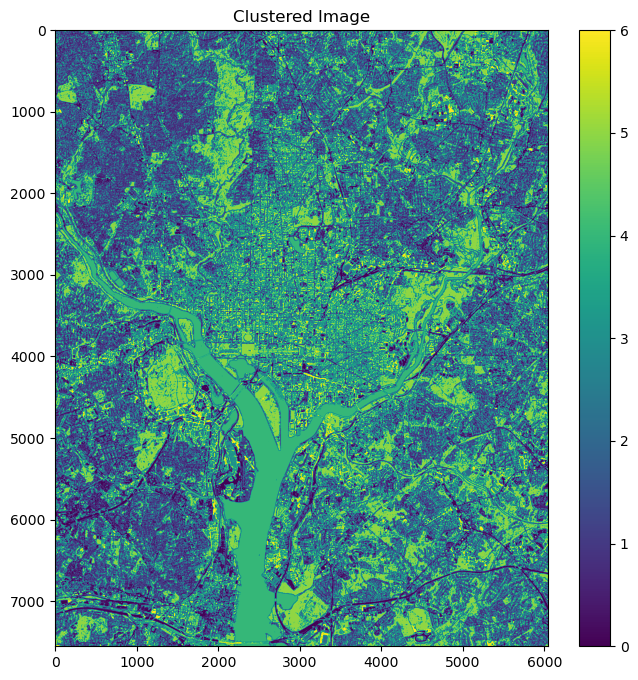

Time elapsed: 1149.0 seconds.


In [14]:
start_time = time.time()

# Load the image
image = io.imread(mnf_path)

# Reshape the image data into a 2D array, where each row is a pixel and each column is a band
# The -1 in the reshape function infers the number of rows based on the other dimensions.
# bands = image.reshape(-1, image.shape[2])
bands = image[:, :, [0, 1]].reshape(-1, 2)
# Optional: Standardize the features
scaler = StandardScaler()
bands_standardized = scaler.fit_transform(bands)
# Apply K-means clustering
n_clusters = [3,5,7]  # Adjust the number of clusters as needed
for n in n_clusters:
    N = str(n)
    kmeans = KMeans(n_clusters=n, n_init=25, random_state=42)
    clusters = kmeans.fit_predict(bands_standardized)

    # Reshape the cluster assignments to match the original image shape
    clustered_image_ = clusters.reshape(1, image.shape[0], image.shape[1])
    print(clustered_image_.shape)
    # Convert the array to a TIFF for export
    out_kmeans_path = os.path.join(projdir,f'data/spatial/mod/dc_data/results/dc_data_mnf_kmeans{N}.tif')
    out_kmeans = array_to_tif(clustered_image_.T, stack_mnf, out_kmeans_path, 'uint8', clip=False, shp=None)

    # Visualize the clustered image
    plt.figure(figsize=(8, 8))
    plt.imshow(clusters.reshape(image.shape[0], image.shape[1]))
    plt.title('Clustered Image')
    plt.colorbar()
    plt.show()
    
    del kmeans, clusters, clustered_image_

print(f"Time elapsed: {round(time.time() - start_time, 1)} seconds.") 

del image, bands, bands_standardized

In [ ]:
##############################################################
# Create a KMeans (N=3,5,7) within a building footprint mask #
##############################################################



In [ ]:
"""
Test the classes by extracting summary statistics within building footprint data, 
vegetation reference samples, and water reference samples
"""

footprints = gpd.read_file()
vegetation = gpd.read_file()
water = gpd.read_file()


In [ ]:
# Create the mask layers
